In [1]:
# загружаю необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats as ss
import statsmodels.api as sm
import datetime as dt
import statsmodels.formula.api as smf
from scipy.stats import norm, levene
from tqdm.auto import tqdm

plt.style.use('ggplot')
from random import randint

In [2]:
sns.set(
    font_scale =1,
    style      ="whitegrid",
    rc         ={'figure.figsize':(9,6)}
)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from IPython.display import Image
Image(url='images/task1.jpg')

In [8]:
# Загружаю данные
reg_data = pd.read_csv('reg_data.csv', sep=',')
auth_data = pd.read_csv('auth_data.csv', sep=',')

In [9]:
reg_data.head(5)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [10]:
auth_data.head(5)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [11]:
# делаю предварительный анализ данных
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [12]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [13]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [14]:
reg_data.uid.duplicated().sum()

0

In [15]:
reg_data.uid.nunique()

1000000

In [16]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [17]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [18]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [19]:
auth_data.uid.duplicated().sum()

8601013

In [20]:
auth_data.uid.nunique()

1000000

<b>Выводы по предварительному анализу.</b> 
* Пустых значений нет. 
* В таблице с регистрациями все идентификаторы пользователей уникальны, значит нито не регистрировался больше 1 раза. 
* В таблице с авторизациями есть дубликаты идентификаторов, но это нормально, т.к. авторизации каждый пользователь может совершать многократно. 
* Время в датафреймах представленно в unix формате в секундах.

In [21]:
# Перевожу unix тип в стандартный вид дата-время, и избавляюсь от времени (т.к оно сейчас не важно)
reg_data['reg_day'] = pd.to_datetime(reg_data['reg_ts'], unit='s').astype('datetime64[D]')
auth_data['auth_day'] = pd.to_datetime(auth_data['auth_ts'], unit='s').astype('datetime64[D]')

In [23]:
# Удаляю исходные столбцы с unix временем
reg_data1 = reg_data.drop('reg_ts', axis=1)
auth_data1 = auth_data.drop('auth_ts', axis=1)

In [24]:
# Мерджу датафреймы с регистрацией и авторизацией
full_data = reg_data1.merge(auth_data1, on='uid')
full_data

,uid,reg_day,auth_day
0,1,1998-11-18,1998-11-18
1,2,1999-07-22,1999-07-22
2,2,1999-07-22,1999-07-25
3,2,1999-07-22,1999-07-31
4,2,1999-07-22,1999-08-05
...,...,...,...
9601008,1110618,2020-09-23,2020-09-23
9601009,1110619,2020-09-23,2020-09-23
9601010,1110620,2020-09-23,2020-09-23
9601011,1110621,2020-09-23,2020-09-23


In [26]:
# Нахожу временнЫе границы для регистраций и авторизаций 
print('Первая дата регистрации:', full_data.reg_day.dt.strftime('%Y-%m-%d').min(), 'Последняя дата регистрации:', full_data.reg_day.dt.strftime('%Y-%m-%d').max())
print('Первая дата авторизации:', full_data.auth_day.dt.strftime('%Y-%m-%d').min(), 'Последняя дата авторизации:', full_data.auth_day.dt.strftime('%Y-%m-%d').max())

Первая дата регистрации: 1998-11-18 Последняя дата регистрации: 2020-09-23
Первая дата авторизации: 1998-11-18 Последняя дата авторизации: 2020-09-23


**Создаю функцию**

In [30]:
# в качестве аргументов подаю датафрейм, первую и последнюю дату, которые задаст пользователь
def retention_rate(df, first_day, last_day):
# отфильтровываю данные в таблице по заданным датам 
    df = df[(df['reg_day'] >= first_day) & (df['auth_day'] <= last_day)]
# создаю столбец с разницей в днях между регистрацией и следующим заходом
    df['sub_days'] = df['auth_day'] - df['reg_day']
# группирую в когорты и считаю количество уникльных пользователей зашедших повторно, переименовываю
    cohorts = df.groupby(['reg_day','sub_days'], as_index=False).agg({'uid':'count'}) \
            .rename(columns={'uid':'counts_uid','reg_day':'cohort_name'})
# перевожу дни в числовой тип
    cohorts['sub_days'] = cohorts['sub_days'].dt.days
# создаю дополнительый датафрейм в который оставляю только тех кто зашел впервые
    cohorts_newfags = cohorts.query("sub_days == 0")
# удаляю ненужный столбец и переименовываю
    cohorts_newfags = cohorts_newfags.drop('sub_days', axis=1).rename(columns={'counts_uid':'newbie'})
# мерджу к изначальной таблице когорт
    cohorts = cohorts.merge(cohorts_newfags, on='cohort_name')   
# создаю новый столбец и считаю в него ретеншен
    cohorts['retention_rate'] = (cohorts['counts_uid'] * 100) / cohorts['newbie']
# округляю   
    cohorts['retention_rate'] = cohorts['retention_rate'].round(2)
# создаю сводную таблицу с ретеншеном
    retention = cohorts.pivot_table(index='cohort_name', columns='sub_days', values='retention_rate')
# возвращаю результат с таблицей

# делаю хитмэп для таблицы
    plt.rcParams['font.size'] = '12'
    plt.figure(figsize=(18,14))
    plt.title('Retention, %')
    ax = sns.heatmap(data=retention, annot=True, vmin=0, vmax=10 ,cmap='Greens', fmt=".1f")
    ax.set_yticklabels(retention.index)
    ax.set_xticklabels(retention.columns)
    fig=ax.get_figure()

    plt.show()
    
    return retention


**Вызов функции, в качестве аргументов пользователь указывает датафрейм, и указывает временной период из доступных**

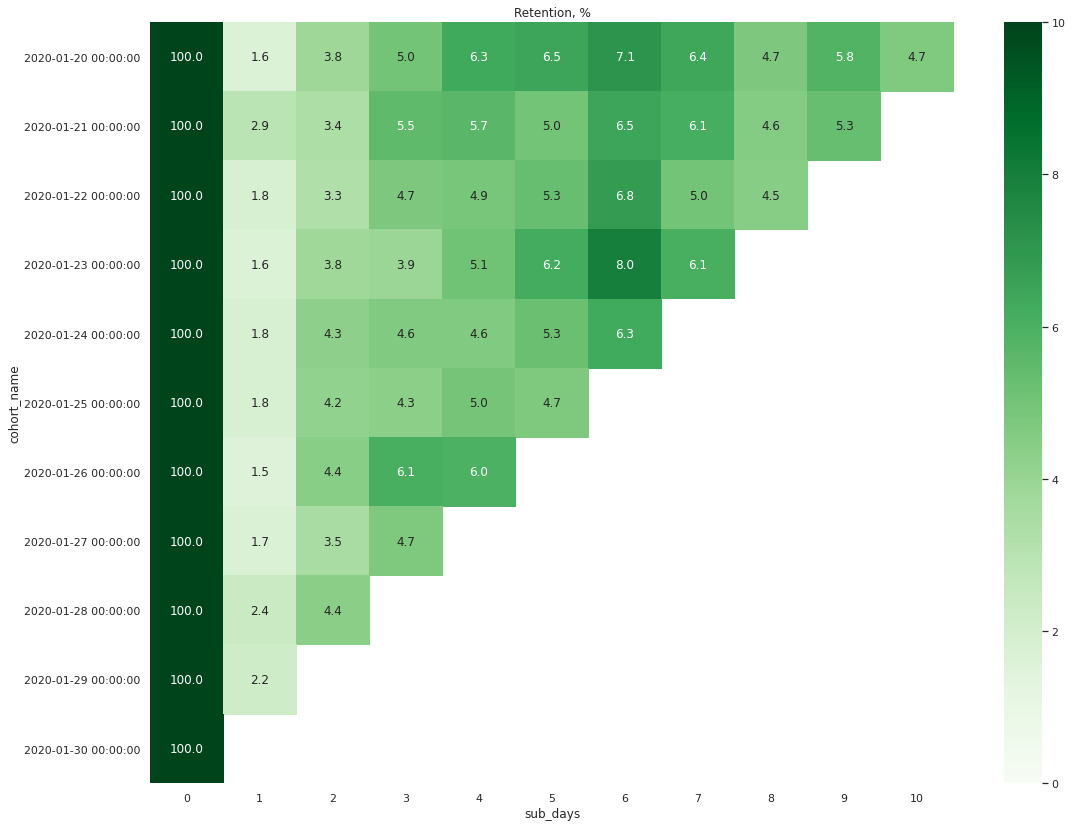

sub_days,0,1,2,3,4,5,6,7,8,9,10
cohort_name,,,,,,,,,,,
2020-01-20,100.0,1.64,3.83,5.02,6.30,6.48,7.12,6.39,4.74,5.84,4.65
2020-01-21,100.0,2.92,3.37,5.47,5.65,5.01,6.47,6.11,4.56,5.29,NaN
2020-01-22,100.0,1.82,3.28,4.73,4.91,5.28,6.82,5.00,4.46,NaN,NaN
2020-01-23,100.0,1.64,3.82,3.91,5.09,6.18,8.00,6.09,NaN,NaN,NaN
2020-01-24,100.0,1.81,4.26,4.62,4.62,5.26,6.26,NaN,NaN,NaN,NaN
2020-01-25,100.0,1.81,4.17,4.35,4.98,4.71,NaN,NaN,NaN,NaN,NaN
2020-01-26,100.0,1.54,4.43,6.06,5.97,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-27,100.0,1.71,3.52,4.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-28,100.0,2.43,4.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
retention_rate(full_data, '2020-01-20', '2020-01-30')

In [25]:
from IPython.display import Image
Image(url='images/task2.jpg')

In [57]:
# Загружаю датафрейм
test_data = pd.read_csv('project_1_zadanie_2.csv', sep=';')
test_data

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [58]:
# провожу предварительную проверку данных
test_data.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [59]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [60]:
test_data.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [61]:
test_data.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


In [62]:
test_data.user_id.nunique()

404770

In [63]:
test_data.user_id.duplicated().sum()

0

**К данным в таблице нет никаких претензий, все типы нужные, нет пропущенных значений, все пользователи уникальные, пересечений пользователей по группам нет. Хочу дополнительно проверить значения заявленные в условии задачи**

In [64]:
# кол-во пользователей в контрольной
test_data.query("testgroup == 'a'").user_id.nunique()

202103

In [65]:
 # кол-во пользователей в тестовой
test_data.query("testgroup == 'b'").user_id.nunique()

202667

In [66]:
# кол-во платящих пользователей в контрольной
test_data.query("testgroup == 'a' and revenue > 0 ").shape 

(1928, 3)

In [67]:
# кол-во платящих пользователей в тестовой
test_data.query("testgroup == 'b' and revenue > 0 ").shape

(1805, 3)

**Тут все заявленные значения тоже сошлись**

**Приступаю к расчетам. Высчитываю итоговые показатели**

In [68]:
# Хочу создать таблицу с итоговыми показателями для двух групп  
# Добавляю столбец с булевым значением для пользователя (1=платящий\0=неплатящий)
test_data['paying_users'] = test_data['revenue'].apply(lambda x: 1 if x > 0 else 0)

In [69]:
test_data

,user_id,revenue,testgroup,paying_users
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0
...,...,...,...,...
404765,404766,0,a,0
404766,404767,0,b,0
404767,404768,231,a,1
404768,404769,0,a,0


In [70]:
# Делаю группировку, и считаю интересующие меня итоговые показатели
test_summary = test_data.groupby('testgroup', as_index=False).agg({'user_id':'nunique','revenue':'sum','paying_users':'sum'}) \
    .rename(columns={'user_id':'total_users','revenue':'total_revenue'})

In [71]:
test_summary

,testgroup,total_users,total_revenue,paying_users
0,a,202103,5136189,1928
1,b,202667,5421603,1805


<b> Теперь хочу посчитать следующие метрики: 
* Конверсию (CR) - отношение платящих пользователей, ко всем пользователям. 
* ARPU - средний доход с одного пользователя
* ARPPU - средний доход с одного платящего пользователя </b> 

**Высчитываю метрики (конверсия, ARPU, ARPPU)**

In [72]:
test_summary['CR_%'] = ( test_summary.paying_users / test_summary.total_users ) * 100
test_summary['ARPU_$'] = test_summary.total_revenue / test_summary.total_users
test_summary['ARPPU_$'] = test_summary.total_revenue / test_summary.paying_users

In [73]:
# Итоговая таблица для двух групп
test_summary

,testgroup,total_users,total_revenue,paying_users,CR_%,ARPU_$,ARPPU_$
0,a,202103,5136189,1928,0.953969,25.413720,2663.998444
1,b,202667,5421603,1805,0.890624,26.751287,3003.658172


<b>Сравниваю конверсию в группах</b>

In [74]:
# убыль
1 - (test_summary['CR_%'][1] / test_summary['CR_%'][0])

0.06640203150326496

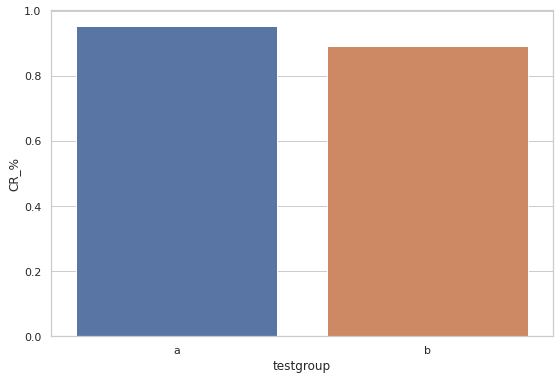

In [75]:
sns.barplot(data=test_summary, y='CR_%', x='testgroup')

<b>Вывод: конверсия в тестовой группе B снизилась на 7% относительно контрольной группы A </b>

<b>Сравниваю ARPU в группах</b>

In [76]:
# прирост
test_summary['ARPU_$'][1] / test_summary['ARPU_$'][0]

1.052631683600699

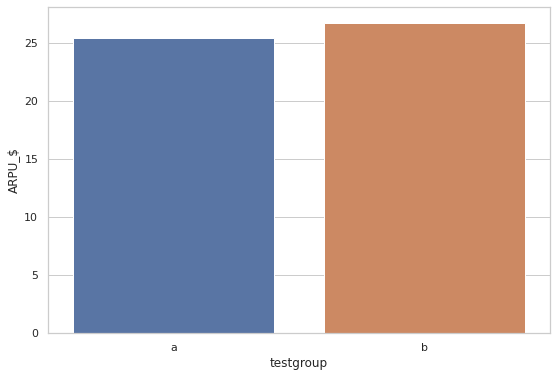

In [77]:
sns.barplot(data=test_summary, y='ARPU_$', x='testgroup')

<b>Вывод: ARPU в тестовой группе B увеличился на 5% относительно контрольной группы A </b>

<b>Считаю ARPPU в группах</b>

In [78]:
# прирост
test_summary['ARPPU_$'][1] / test_summary['ARPPU_$'][0]

1.1274999722799635

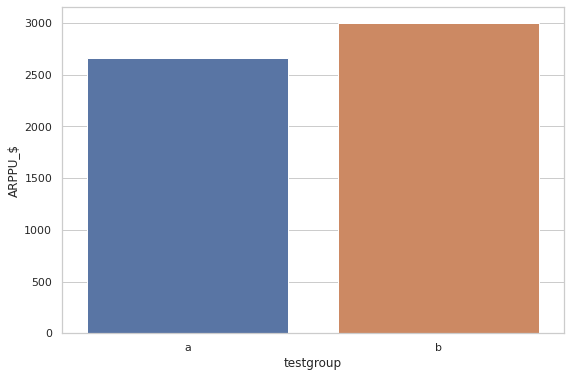

In [79]:
sns.barplot(data=test_summary, y='ARPPU_$', x='testgroup')

<b>Вывод: ARPPU в тестовой группе B увеличился на 13% относительно контрольной группы A </b>

<b>Строю графики распределений значений</b>

In [80]:
# Для удобства выношу группы в отдельные датафреймы
control_group = test_data.query("testgroup == 'a'")
test_group = test_data.query("testgroup == 'b'")

In [81]:
control_group

,user_id,revenue,testgroup,paying_users
1,2,0,a,0
2,3,0,a,0
9,10,0,a,0
10,11,0,a,0
11,12,0,a,0
...,...,...,...,...
404760,404761,0,a,0
404762,404763,0,a,0
404765,404766,0,a,0
404767,404768,231,a,1


In [82]:
test_group

,user_id,revenue,testgroup,paying_users
0,1,0,b,0
3,4,0,b,0
4,5,0,b,0
5,6,0,b,0
6,7,0,b,0
...,...,...,...,...
404761,404762,0,b,0
404763,404764,0,b,0
404764,404765,0,b,0
404766,404767,0,b,0


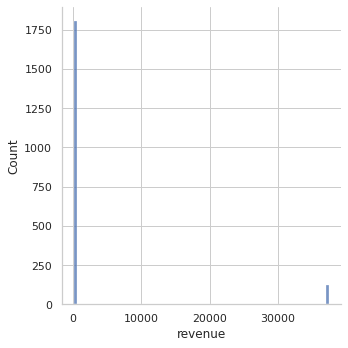

In [83]:
# Строю графики распределения выручки с платящих пользователей в обеих группах
sns.displot(control_group.query("paying_users == 1").revenue, bins=100)

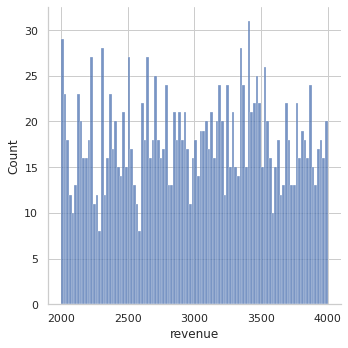

In [84]:
sns.displot(test_group.query("paying_users == 1").revenue, bins=100)

**Распределение для тестовой группы равномерно, а вот для в контрольной имеется некоторое количество (около 10%) экстремальных значений, которые делают график экспоненциальным падением с выбросами на конце**

**Хочу посмотреть на выбросы**

In [85]:
control_group.query("revenue > 30000")

,user_id,revenue,testgroup,paying_users
416,417,37324,a,1
4428,4429,37304,a,1
5777,5778,37315,a,1
8065,8066,37307,a,1
8743,8744,37334,a,1
...,...,...,...,...
360696,360697,37347,a,1
378668,378669,37297,a,1
389341,389342,37298,a,1
394580,394581,37302,a,1


In [86]:
control_group.query("revenue > 30000").revenue.min()

37293

In [87]:
control_group.query("revenue < 30000").revenue.max()

400

**Вижу что существует разрыв в почти 10 раз между значениям 400 и 37293  
Считаю какую долю составляют платящие пользователи c экстремальными значениями (в %)**

In [88]:
control_fraction_users = (control_group.query("revenue >= 37293").revenue.count()) / control_group.query("paying_users == 1").revenue.count() * 100
control_fraction_users

6.379668049792531

**Считаю какую долю составляет выручка от платящих пользователей c экстремальными значениями (в %)**

In [89]:
control_fraction_revenue = (control_group.query("revenue >= 37293").revenue.sum()) / control_group.query("paying_users == 1").revenue.sum() * 100
control_fraction_revenue

89.37077665950378

**Беру полученные показатели, и проецирую их на тестовую группу процентилями, чтобы найти аналогичные значения в тестовой группе**

In [90]:
test_group.query("paying_users == 1").revenue.quantile(q=(1-control_fraction_users/100))

3866.910788381743

**Получаю границу по выручке, верхние 6.38% в тестовой группе платят суммы от 3866.91  
Теперь возьму эту границу, и посчитаю отношение по сумме выручке верхних 6.38% пользователей, ко всем 100% платящим**

In [91]:
test_fraction_users = test_group.query("paying_users == 1 and revenue >= 3866.91").revenue.sum()/ test_group.query("paying_users == 1").revenue.sum() * 100
test_fraction_users

8.416219335868009

In [92]:
control_fraction_revenue/test_fraction_users

10.618874472368596

<b>Вывод: количество пользователей (6.37%) в контрольной группе с выбросами платежей формируют 89% всей выручки, и оказывают в 10.6 раз большее значение на распределение, чем тот же процент (6.37%) пользователей с максимальными платежами в контрольной группе (формируют 8.42% выручки) </b>

**Считаю средние и медианы для двух групп**

In [93]:
control_group.query("paying_users == 1").revenue.mean()

2663.9984439834025

In [94]:
control_group.query("paying_users == 1").revenue.median()

311.0

In [95]:
test_group.query("paying_users == 1").revenue.mean()

3003.6581717451522

In [96]:
test_group.query("paying_users == 1").revenue.median()

3022.0

**Среднее и медиана в контрольной группе отличаются почти в 10 раз, а вот в тестовой они практически одинаковые.  
Построю распределение платежей в контрольной группе, исключив экстремально большие значения**

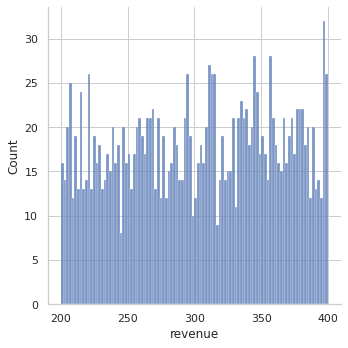

In [97]:
sns.displot(control_group.query("paying_users == 1 and revenue < 37293").revenue, bins=100)

**Построю распределение платежей в контрольной группе, только экстремально больших значений**

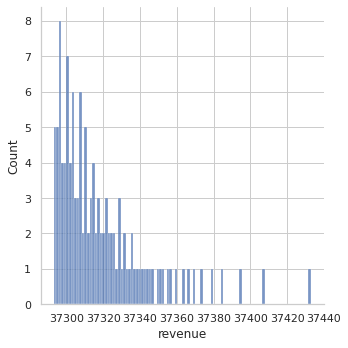

In [98]:
sns.displot(control_group.query("paying_users == 1 and revenue >= 37293").revenue, bins=100)

**Без экстремальных значений распределение равномерное, а только для экстремальных экпоненциальное**  

<b>Теперь приступаю к статистическим тестированиям</b>  
**Проверяю распределения платежей в группах на нормальность распределения тестом Колмогорова-Смирнова**

In [99]:
ss.normaltest(test_group.query("paying_users == 1").revenue)

NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)

In [100]:
ss.normaltest(control_group.query("paying_users == 1").revenue)

NormaltestResult(statistic=1394.9457843086925, pvalue=1.2341605505935488e-303)

**Для обеих групп тест показал экстремально низкое значение p-value, отвергаю нулевую теорию о том, что распеделения являются нормальным.  
Проверяю распределения платежей в группах на равенство дисперсий тестом Левена**

In [101]:
ss.levene(control_group.query("paying_users == 1").revenue,test_group.query("paying_users == 1").revenue, center='median')

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

**Для обеих групп тест показал экстремально низкое значение p-value, отвергаю нулевую теорию о равенстве дисперсий.  
Поскольку распределения не являются нормальными и имеют разную дисперсию для дальнейшего тестирования я буду применять Бутстрап статистику.**

<b>Гипотеза1: Средние в двух группах не отличаются</b>

**Использую функцию расчета доверительного интервала для средних между двумя группами**

In [103]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

<b>Посчитаю статистику для средних по ARPPU</b>

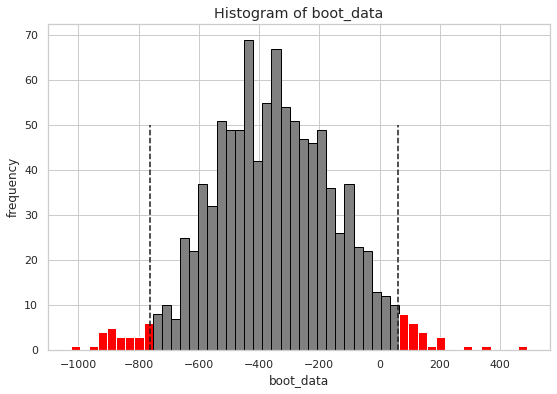

In [104]:
 # в результате хранится разница двух распределений, ДИ и pvalue
boot_mean_arppu = get_bootstrap(control_group.query("paying_users == 1").revenue, test_group.query("paying_users == 1").revenue)

In [105]:
boot_mean_arppu["p_value"] # альфа

0.09577341154852079

In [106]:
boot_mean_arppu["quants"] # ДИ

,0
0.025,-761.156950
0.975,62.277814


<b>Вывод: значение p-value > 0.05, а доверительный интервал включает 0, тем самым не могу отвергнуть нулевую теорию, и должен считать, что среднее в двух группах для платящих не отличаются </b>

<b>Посчитаю статистику для средних по ARPU</b>

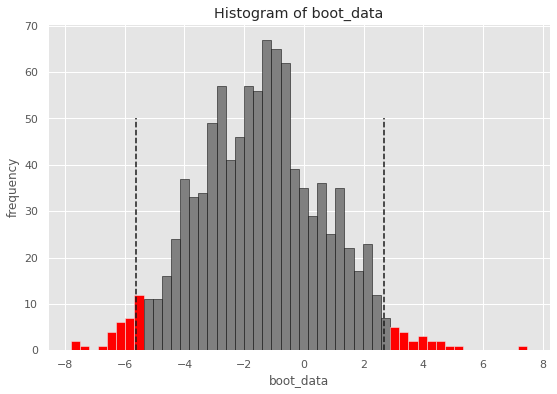

In [55]:
# в результате хранится разница двух распределений, ДИ и pvalue
boot_mean_arpu = get_bootstrap(control_group.revenue, test_group.revenue) 

In [58]:
boot_mean_arpu["p_value"] # альфа

0.5031537094439547

In [59]:
boot_mean_arpu["quants"] # ДИ

,0
0.025,-5.632497
0.975,2.669231


<b>Вывод: значение p-value > 0.05, а доверительный интервал включает 0, тем самым не могу отвергнуть нулевую теорию, и должен считать, что среднее в двух группах для всех пользователей не отличаются </b>

<b>Гипотеза 2: хочу проверить средние обех групп для ARPPU и ARPU, исключив максимальные значения платежей, которые я получил ранее (для контрольной группы это 37293, для тестовой это 3867). Изменится ли результат или средние так же будут равны?</b>

<b>Среднее для ARPPU</b>

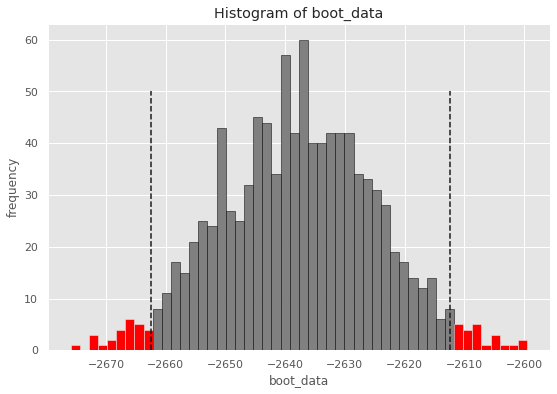

In [60]:
 # в результате хранится разница двух распределений, ДИ и pvalue
boot_mean_arppu_notmax = get_bootstrap(control_group.query("paying_users == 1 and revenue < 37293").revenue, test_group.query("paying_users == 1 and revenue < 3867").revenue)

In [61]:
boot_mean_arppu_notmax["p_value"] # альфа

0.0

In [62]:
boot_mean_arppu_notmax["quants"] # ДИ

,0
0.025,-2662.536981
0.975,-2612.365928


In [63]:
control_group.query("paying_users == 1 and revenue < 37293").revenue.mean()

302.45817174515236

In [64]:
test_group.query("paying_users == 1 and revenue < 3867").revenue.mean()

2939.7921847246894

<b>Вывод: результат изменился, средние значения статистически значимо отличаются, среднее в тестовой группе почти в 10 раз больше чем в контрольной </b>

<b> Среднее для ARPU</b>


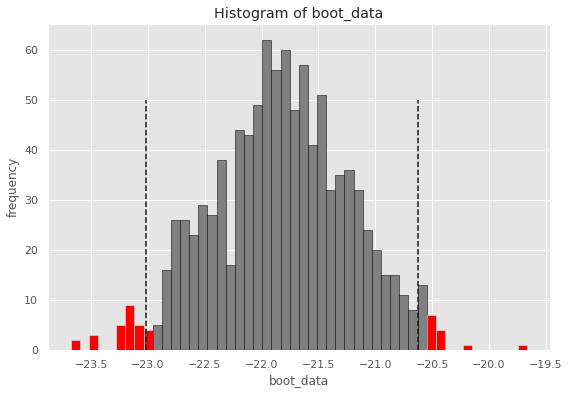

In [107]:
 # в результате хранится разница двух распределений, ДИ и pvalue
boot_mean_arpu_notmax = get_bootstrap(control_group.query("revenue < 37293").revenue, test_group.query("revenue < 3867").revenue)

In [66]:
boot_mean_arpu_notmax["p_value"] # альфа

3.2378651300943815e-278

In [67]:
boot_mean_arpu_notmax["quants"] # ДИ

,0
0.025,-23.003316
0.975,-20.604639


In [68]:
control_group.query("revenue < 37293").revenue.mean()

2.702926032280424

In [69]:
test_group.query("revenue < 3867").revenue.mean()

24.513870580742626

<b>Вывод: результат изменился, средние значения статистически значимо отличаются, среднее в тестовой группе почти в 10 раз больше чем в контрольной </b>

 <b>Гипотеза 3: предположим платящие пользователи с экстримально большими платящими значениями могли попасть в выборку случайно. Известно что их количество 6.38%. Что если оставить в выборке обеих групп только случайные 93.62% пользователей от всей выборки. Изменится ли результат или останется такой же как для полных групп?</b>

**Для расчета этой гипотезы, мне нужно изменить функцию и добавить в неё рандомайзер рандомайзер**

In [75]:
# new
def get_bootstrap_random(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    ran, # размер рандома который нужно убрать, в процентах от 100
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    y = len(data_column_1) # определяю изначальную длинну столбца таблицы 1, т.к. в дальнейшем эта таблица изменится
    
    data_column_1 = data_column_1.sample(frac=ran, replace = True) # рандомайзер для контрольной группы
    data_column_2 = data_column_2.sample(frac=ran, replace = True) # рандомайзер для тестовой группы
    
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        
        samples_1 = data_column_1.sample(
            y, # длинна первой таблицы
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            y, # длинна первой таблицы
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

черновик, не удалять

In [70]:
# олд
from random import randint

def get_bootstrap_random(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    ran, # размер рандома который нужно убрать, в процентах от 100
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    y = len(data_column_1) # определяю изначальную длинну столбца таблицы 1, т.к. в дальнейшем эта таблица изменится
    
    data_column_1 = data_column_1.reset_index(drop = True) # сбрасываю индексы чтобы было по порядку
    n = data_column_1.shape[0]-1 # создаю счетчик индексов столбца
    for i in range (int(data_column_1.shape[0]*ran/100)): # перебор в размере длинна столбца * рандом
        data_column_1 = data_column_1.drop(index = randint(0, n)) # дропаю 1 случайную строку и перезаписываю столбец
        n = n-1 # сокращаю индексы на 1
        data_column_1 = data_column_1.reset_index(drop = True) # снова сбрасываю индексы, тк 1 из них был удален

    data_column_2 = data_column_2.reset_index(drop = True)
    m = data_column_2.shape[0]-1
    for i in range (int(data_column_2.shape[0]*ran/100)):
        data_column_2 = data_column_2.drop(index = randint(0, m))
        m = m-1
        data_column_2 = data_column_2.reset_index(drop = True)
    
    
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        
        samples_1 = data_column_1.sample(
            y, # длинна первой таблицы
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            y, # длинна первой таблицы
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}


черновик, не удалять

In [ ]:
    ran = 5 # количество рандома, в процентах
    data_column_1 = data_column_1.reset_index(drop = True) # сбрасываю индексы чтобы было по порядку
    n = data_column_1.shape[0]-1 # создаю счетчик индексов столбца
    for i in range (int(data_column_1.shape[0]*ran/100)): # перебор в размере длинна столбца * рандом
        data_column_1 = data_column_1.drop(index = randint(0, n)) # дропаю 1 случайную строку и перезаписываю столбец
        n = n-1 # сокращаю индексы на 1
        data_column_1 = data_column_1.reset_index(drop = True) # снова сбрасываю индексы, тк 1 из них был удален

<b>Средние для ARPPU</b>


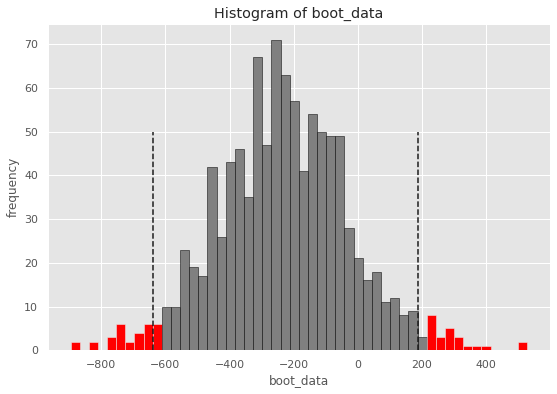

In [79]:
 # в результате хранится разница двух распределений, ДИ и pvalue
booted_arppu_ifnot638 = get_bootstrap_random(control_group.query("paying_users == 1").revenue, test_group.query("paying_users == 1").revenue, 6.38)

In [80]:
booted_arppu_ifnot638["p_value"] # альфа

0.2575446024753333

In [81]:
booted_arppu_ifnot638["quants"] # ДИ

,0
0.025,-638.589315
0.975,188.255809


<b>Средние для ARPU</b>

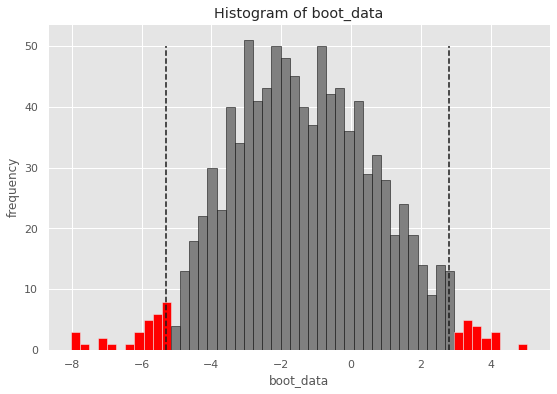

In [82]:
# в результате хранится разница двух распределений, ДИ и pvalue
booted_arpu_ifnot638 = get_bootstrap_random(control_group.revenue, test_group.revenue, 6.38) 

In [83]:
booted_arpu_ifnot638["p_value"] # альфа

0.523352443348007

In [84]:
booted_arpu_ifnot638["quants"] # ДИ

,0
0.025,-5.289953
0.975,2.811042


<b>Вывод: оба тестирования не показали статистически значимые различия </b>

<b> Гипотеза 4: я узнал что конверсия в тестовой группе упала на 6.64%. Так как для бизнеса финансовая выгода привалирует над значением конверсии, и, если принять за правду, что выручка в тестовой группе увеличилась, то мы неминуемо потеряем эти 6.64% платящих пользователей. Поэтому я хочу отсечь эту часть из контрольной группы, и посмотреть, изменится ли результат по сравнениею с полноценными группами. </b>

**Новая функция для это гипотезы**

In [85]:
def get_bootstrap_random_notcr(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    ran, # размер рандома который нужно убрать, в процентах от 100
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    y = len(data_column_1) # определяю изначальную длинну столбца таблицы 1, т.к. в дальнейшем эта таблица изменится
    
    data_column_1 = data_column_1.sample(frac=ran, replace = True) # рандомайзер для контрольной группы
    
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        
        samples_1 = data_column_1.sample(
            y, # длинна первой таблицы
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            y, # длинна первой таблицы
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

<b>Средние для ARPPU</b>

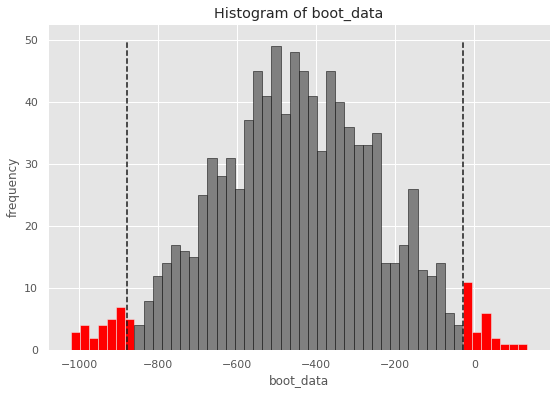

In [86]:
 # в результате хранится разница двух распределений, ДИ и pvalue
booted_arppu_ifnot664 = get_bootstrap_random_notcr(control_group.query("paying_users == 1").revenue, test_group.query("paying_users == 1").revenue, 6.64)

In [87]:
booted_arppu_ifnot664["p_value"] # альфа

0.031479311482674154

In [88]:
booted_arppu_ifnot638["quants"] # ДИ

,0
0.025,-638.589315
0.975,188.255809


<b>Вывод: тест показал, что средние различаются </b>

<b>Среднее для ARPU</b>

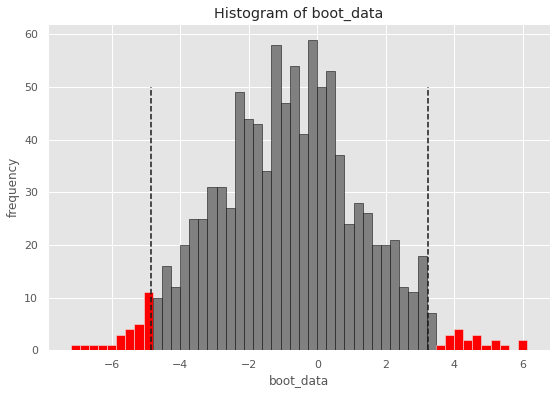

In [91]:
 # в результате хранится разница двух распределений, ДИ и pvalue
booted_arpu_ifnot664 = get_bootstrap_random_notcr(control_group.revenue, test_group.revenue, 6.64)

In [92]:
booted_arpu_ifnot664["p_value"] # альфа

0.6971730349151661

In [93]:
booted_arpu_ifnot664["quants"] # ДИ

,0
0.025,-4.861616
0.975,3.224472


**Вывод: тест не выявил различий**

<b>Теперь я проведу все теже тесты, только теперь с помощью бутстрап функции буду считать не среднее, а медиану.  
Заменяю нужную статистику на медиану</b>

In [94]:
def get_bootstrap_median(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

<b>Гипотеза 5: Медианы в двух группах не отличаются.</b>  
<b>Посчитаю статистику для медиан по ARPPU</b>

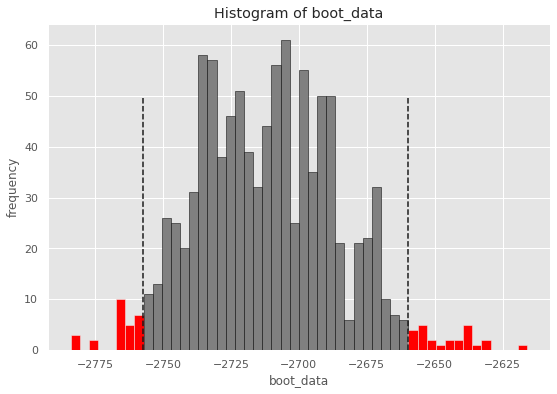

In [95]:
boot_median_arppu = get_bootstrap_median(control_group.query("paying_users == 1").revenue, test_group.query("paying_users == 1").revenue) # в результате хранится разница двух распределений, ДИ и pvalue

In [96]:
boot_median_arppu["p_value"] # альфа

0.0

In [97]:
boot_median_arppu["quants"] # ДИ

,0
0.025,-2757.5125
0.975,-2659.9750


<b>Вывод: Статистика говорит, что медианы в двух группах статистически значимо отличаются </b>

<b>Посчитаю статистику для медиан по ARPU</b>

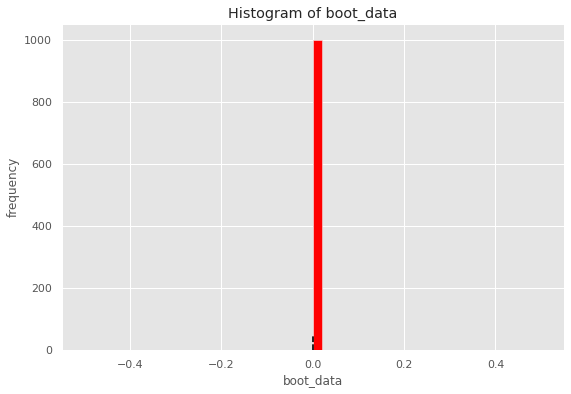

In [98]:
# в результате хранится разница двух распределений, ДИ и pvalue
boot_median_arpu = get_bootstrap_median(control_group.revenue, test_group.revenue) 

In [99]:
boot_median_arpu["p_value"] # альфа

nan

In [100]:
boot_median_arpu["quants"] # ДИ

,0
0.025,0.0
0.975,0.0


In [101]:
control_group.revenue.median()

0.0

In [102]:
test_group.revenue.median()

0.0

<b>Вывод: т.к. в обоих группа количество платящих составляет меньше 1%, то медианы всегда будут выпадать на неплатящих со значеним 0, и их сравнение бессмыслено </b>

<b>Гипотеза 6: хочу проверить медианы обех групп для ARPPU и ARPU, исключив максимальные значения платежей, которые я получил ранее (для контрольной группы это 37293, для тестовой это 3867). Изменится ли результат или средние так же будут равны?</b>  

<b>Медианы для ARPPU</b>

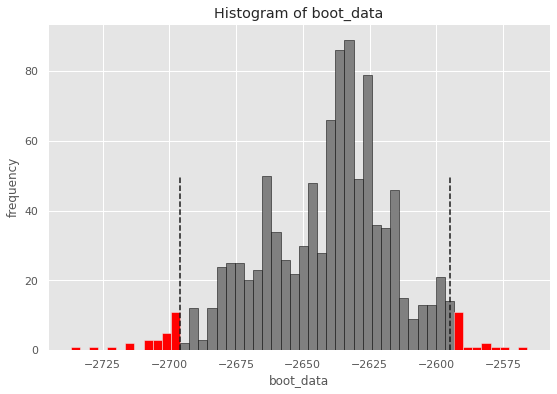

In [103]:
boot_median_arppu_notmax = get_bootstrap_median(control_group.query("paying_users == 1 and revenue < 37293").revenue, test_group.query("paying_users == 1 and revenue < 3867").revenue) # в результате хранится разница двух распределений, ДИ и pvalue

In [104]:
boot_median_arppu_notmax["p_value"] # альфа

0.0

In [105]:
boot_median_arppu_notmax["quants"] # ДИ

,0
0.025,-2696.0
0.975,-2595.0


In [106]:
control_group.query("paying_users == 1 and revenue < 37293").revenue.median()

305.0

In [107]:
test_group.query("paying_users == 1 and revenue < 3867").revenue.median()

2943.0

<b>Вывод: результат изменился, средние значения статистически значимо отличаются </b>

<b>Медианы для ARPU</b>

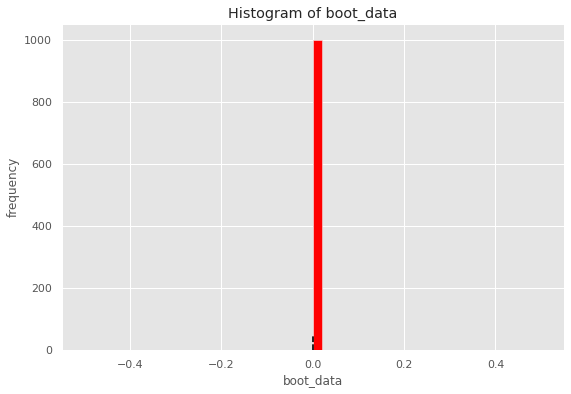

In [109]:
boot_median_arpu_notmax = get_bootstrap_median(control_group.query("revenue < 37293").revenue, test_group.query("revenue < 3867").revenue) # в результате хранится разница двух распределений, ДИ и pvalue

In [110]:
boot_median_arpu_notmax["p_value"] # альфа

nan

In [111]:
boot_median_arpu_notmax["quants"] # ДИ

,0
0.025,0.0
0.975,0.0


In [112]:
control_group.query("revenue < 37293").revenue.median()


0.0

In [113]:
test_group.query("revenue < 3867").revenue.median()

0.0

<b>Вывод: т.к. в обоих группа количество платящих составляет меньше 1%, то медианы всегда будут выпадать на неплатящих со значеним 0, и их сравнение бессмыслено </b>

 <b>Гипотеза 7: предположим платящие пользователи с экстримально большими платящими значениями могли попасть в выборку случайно. Известно что их количество 6.38%. Что если оставить в выборке обеих групп только случайные 93.62% пользователей от всей выборки. Изменится ли результат или останется такой же как для полных групп?</b>

**Новая функция с рандомом в 2 группах, и расчетом медианы**


In [115]:
def get_bootstrap_random_median(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    ran, # размер рандома который нужно убрать, в процентах от 100
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    y = len(data_column_1) # определяю изначальную длинну столбца таблицы 1, т.к. в дальнейшем эта таблица изменится
    
    data_column_1 = data_column_1.sample(frac=ran, replace = True) # рандомайзер для контрольной группы
    data_column_2 = data_column_2.sample(frac=ran, replace = True) # рандомайзер для тестовой группы
    
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        
        samples_1 = data_column_1.sample(
            y, # длинна первой таблицы
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            y, # длинна первой таблицы
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

<b>Медианы для ARPPU</b>


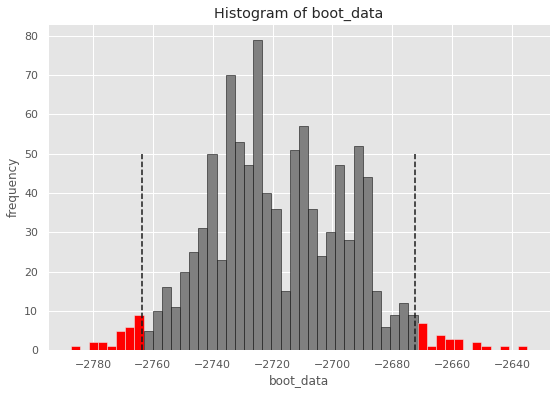

In [116]:
booted_median_arppu_ifnot638 = get_bootstrap_random_median(control_group.query("paying_users == 1").revenue, test_group.query("paying_users == 1").revenue, 6.38) # в результате хранится разница двух распределений, ДИ и pvalue

In [117]:
booted_median_arppu_ifnot638["p_value"] # альфа

0.0

In [118]:
booted_median_arppu_ifnot638["quants"] # ДИ

,0
0.025,-2763.5125
0.975,-2672.5000


<b>Вывод: статистика показала значимые различия </b>

<b>Медианы для ARPU</b>

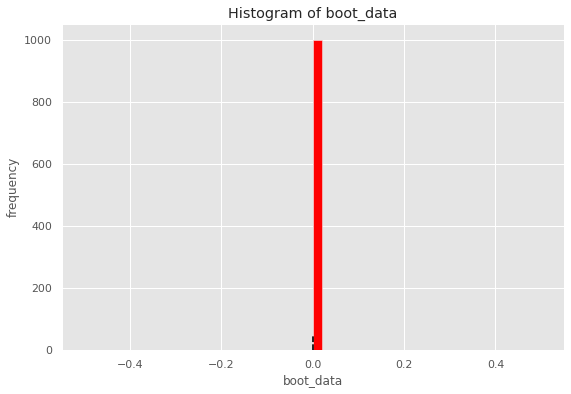

In [120]:
booted_median_arpu_ifnot638 = get_bootstrap_random_median(control_group.revenue, test_group.revenue, 6.38) # в результате хранится разница двух распределений, ДИ и pvalue

In [121]:
booted_median_arpu_ifnot638["p_value"] # альфа

nan

In [122]:
booted_median_arpu_ifnot638["quants"] # ДИ

,0
0.025,0.0
0.975,0.0


<b>Вывод: Вычисление медиан для ARPU не имеет смысла </b>

<b> Гипотеза 8: ранее я узнал что конверсия в тестовой группе упала на 6.64%. Так как для бизнеса финансовая выгода привалирует над значением конверсии, и, если принять за правду, что выручка в тестовой группе увеличилась, то мы неминуемо потеряем эти 6.64% платящих пользователей. Поэтому я хочу отсечь эту часть из контрольной группы, и посмотреть, изменится ли результат по сравнениею с полноценными группами. </b>

**Новая функция**

In [123]:
def get_bootstrap_random_median_notcr(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    ran, # размер рандома который нужно убрать, в процентах от 100
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    y = len(data_column_1) # определяю изначальную длинну столбца таблицы 1, т.к. в дальнейшем эта таблица изменится
    
    data_column_1 = data_column_1.sample(frac=ran, replace = True) # рандомайзер для контрольной группы
    
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        
        samples_1 = data_column_1.sample(
            y, # длинна первой таблицы
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            y, # длинна первой таблицы
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

<b>Медианы для ARPPU</b>

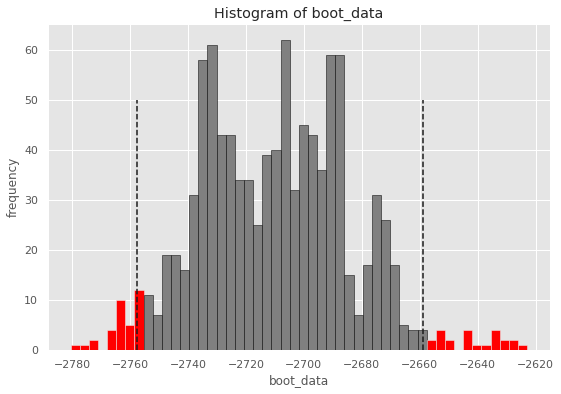

In [124]:
booted_median_arppu_ifnot664 = get_bootstrap_random_median_notcr(control_group.query("paying_users == 1").revenue, test_group.query("paying_users == 1").revenue, 6.64) # в результате хранится разница двух распределений, ДИ и pvalue

In [125]:
booted_median_arppu_ifnot664["p_value"] # альфа

0.0

In [126]:
booted_median_arppu_ifnot664["quants"] # ДИ

,0
0.025,-2757.5125
0.975,-2658.9875


<b>Вывод: тест показал статистически значимые разлиция </b>

<b>Для ARPU</b>

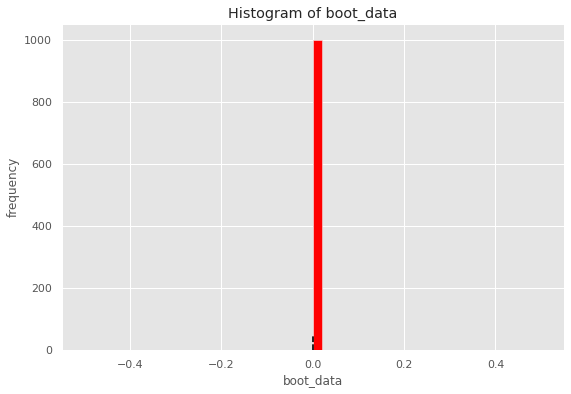

In [127]:
booted_median_arpu_ifnot664 = get_bootstrap_random_median_notcr(control_group.revenue, test_group.revenue, 6.64) # в результате хранится разница двух распределений, ДИ и pvalue

In [128]:
booted_median_arpu_ifnot664["p_value"] # альфа

nan

In [129]:
booted_median_arpu_ifnot664["quants"] # ДИ

,0
0.025,0.0
0.975,0.0


<b>Вывод: тест для ARPU проводить бессмысленно </b>

### <b>Итоги тестирования:</b> 

* <b>Метрика ARPU в тестовой группе увеличилась на 5%</b>
* <b>Метрика ARPPU в тестовой группе увеличилась на 12%</b>
* <b>Конверсия в тестовой группе уменьшилась на 7%</b><br>

Я обнаружил, что контрольная группа имеет экстремальные выбросы по платежам, когда 6% от платящих пользователей приносят 89% дохода, против 8% дохода от аналогичного количества платящях пользователей в тестовой группе. <br>

Я провел сравнения двух групп с помощью статистических критериев, и, несмотря на то что экстремально большие платежи внесли неопределенность в некоторые из тестов, в общем тесты показали, что увеличение прибыли в тестовой группе действительно является статистически значимым. 

Я прихожу к выводу, что <b>набор предложений для тестовой группы b является лучше</b>. 

**Однако, окончательный вывод стоит делать только на основе данных по затратам на поддерждание нового набора предложений. Количество платящих пользователей увеличилось в 10 раз, соответственно и возрасла нагрузка на их обслуживание. Каковы затраты на поддержание нового предложение мне не известны, поэтому не имея этой информации окончательный вывод я сделать не могу, и передаю результаты проделаной работы менеджерам.**

Так же <b>набор тестовой группы имеет потенциал для дальнейшего роста</b>. Из него выпал сегмент премиальных пользователей (платящих самые большие суммы), но и без них удалось добиться большей выручки. А следовательно, если разработать для этого сегмента дополнительный набор предложений, то его (сегмент) можно будет восстановить их, а то и так же увеличить выручку, что так же может и подтянуть конверсию к положительной направленности<br>

In [29]:
from IPython.display import Image
Image(url='images/task3.jpg')

Метрики для первой ситации:
* DAU - количество уникальных пользователей в сравнении дней события, и таких же дней без события
* NPS - отзывы которые событие может получить от пользователей
* ASL - среднее продолжительность сессии в сравнении дней события, и таких же дней без события
* RR - возврат уже зарегстрированных пользователей в сравнении дней события, и таких же дней без события
* CPAcq - затраты на превлеченных пользователей за счет рекламы события. Удалось ли минимализировать затраты по сравнению со стоимость привлечения в дни без событий

Метрики для второй ситуаци: подойдут теже метрики, что и для первой ситации, только в отрицательную сторону. Однако изза откатов на предыдущие уровни, сессия может увеличится, но прогресс игроков окажется на месте, что может привести к отрицательным отзывам